## Instacart market basket analysis

### Description

In this notebook we are trying to solve the kaggle challenge "Instacart market basket analysis". 
Instacart is a grocery ordering and delivering app which lets us do online shopping of food related items. After we select food items we want, delivery personnels review the order and do shopping for us in stores physically and deliver it to us.


### Business problem
Instacart will ease a customer's shopping experience by suggesting products they may order again on a 'Buy these again' suggestion section. This will save a lot of time for customer by skipping search and select process.

### Problem statement

Here based on customers past orders/purchase we need to predict if an item will be in the customer’s next order or not. So, given an order_id we have to predict space separated products(product_id) which has a chance to be reordered for that order. The result will be evaluated on F1 mean score

### Source

https://www.kaggle.com/c/instacart-market-basket-analysis/

### Data Overview

1. orders.csv -- This file contains details of an order like order_id,user_id,eval_set, order_number,order_dow,order_hour_of_day,days_since_prior_order.

2. products.csv -- This file contains a product’s information like product_id, product_name and department_id and aisle_id.

3. order_products__prior.csv -- details of previous orders and its products (which products were bought in each order) like order_id, product_id, add_to_cart_order, reordered.

4. order_products__train.csv -- contains last order of some customers only

5. department.csv -- details of department

6. aisles.csv -- details of aisle 

### Machine Learning Problem

It is a classification problem where given a customer and his previous orders, we have to predict if a product will be in his/her next order or not. So, basically we have to predict reordered column of the data as target variable.

### Performance metric

Micro-Averaged F1-Score (Mean F1 Score) : As per this challenge the evaluation metric will be 'mean F1 score'. So, 1st we will take all the products which will be predicted as reordered and combine them as space seperated string of product_id. On this F1 mean score will be calculated. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

### Loading all data files

In [2]:
orders= pd.read_csv('data/orders.csv')
orders_products_prior= pd.read_csv('data/order_products__prior.csv')
orders_products_train= pd.read_csv('data/order_products__train.csv')
products= pd.read_csv('data/products.csv')
departments= pd.read_csv('data/departments.csv')
aisles= pd.read_csv('data/aisles.csv')

### check for null values

In [3]:
orders.isnull().any()

order_id                  False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
dtype: bool

only days_since_prior_order coloumn has null values in orders dataframe

In [4]:
orders_products_prior.isnull().any()

order_id             False
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool

In [5]:
orders_products_train.isnull().any()

order_id             False
product_id           False
add_to_cart_order    False
reordered            False
dtype: bool

In [6]:
products.isnull().any()

product_id       False
product_name     False
aisle_id         False
department_id    False
dtype: bool

In [7]:
departments.isnull().any()

department_id    False
department       False
dtype: bool

In [8]:
aisles.isnull().any()

aisle_id    False
aisle       False
dtype: bool

#### So, only days_since_prior_order in orders data has null values

In [9]:
number_of_nulls= orders['days_since_prior_order'].isnull().sum(axis = 0)
print('total no. of values = ',len(orders))
print('no. of null values = ', number_of_nulls)

total no. of values =  3421083
no. of null values =  206209


In [10]:
print(f"percentage of null values is {number_of_nulls/len(orders)*100}%")

percentage of null values is 6.027594185817766%


Remove null values as they are not helpful in our classification task. All the Nans in days_since_prior_order column are because they are 1st orders. We will impute them with value 0.

In [3]:
orders.loc[orders['days_since_prior_order'].isnull(), 'days_since_prior_order'] = 0.0
#https://stackoverflow.com/a/31512025/6868740

In [5]:
orders.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


### Analyzing orders table (EDA)

In [6]:
orders.columns

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')

In [14]:
orders.head(20)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,0.0
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [4]:
orders['eval_set'].value_counts() 

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In orders table we have three sets... train, prior and test

order_dow
0    600905
1    587478
2    467260
3    436972
4    426339
5    453368
6    448761
Name: order_id, dtype: int64


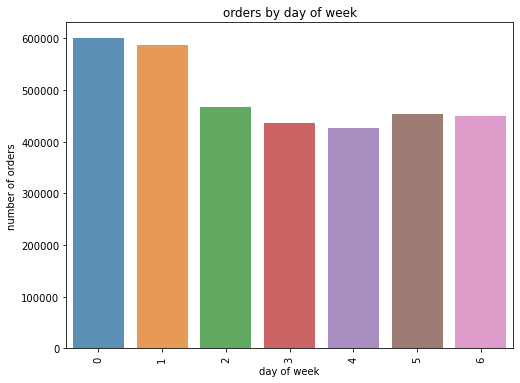

In [8]:
# Now let's check how orders happen with day of week. 

orders_by_dayofweek= orders.groupby('order_dow')['order_id'].count()
print(orders_by_dayofweek.head(10))
plt.figure(figsize=(8,6))
sns.barplot(orders_by_dayofweek.index, orders_by_dayofweek.values, alpha=0.8)
plt.xlabel('day of week')
plt.ylabel('number of orders')
plt.title('orders by day of week')
plt.xticks(rotation='vertical')
plt.show()

#### From above plot it looks like 0 value in 'day of week' is saturday and 1 is sunday as most of the orders happen during weekend intutively. similarily 2:monday, 3:tuesday, 4:wednesday, 5:thursday, 6: friday.  

order_hour_of_day
0      22758
1      12398
2       7539
3       5474
4       5527
5       9569
6      30529
7      91868
8     178201
9     257812
10    288418
11    284728
12    272841
13    277999
14    283042
15    283639
16    272553
17    228795
18    182912
19    140569
20    104292
21     78109
22     61468
23     40043
Name: order_id, dtype: int64


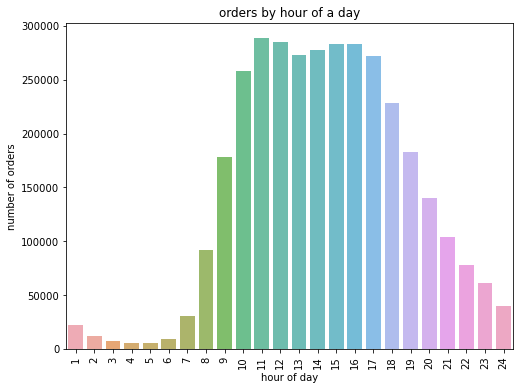

In [9]:
# Now analyze order_hour_of_day 

orders_by_hour= orders.groupby('order_hour_of_day')['order_id'].count()
print(orders_by_hour.head(24))
plt.figure(figsize=(8,6))
sns.barplot(orders_by_hour.index +1, orders_by_hour.values, alpha=0.8)
plt.xlabel('hour of day')
plt.ylabel('number of orders')
plt.title('orders by hour of a day')
plt.xticks(rotation='vertical')
plt.show()

#### Above visualization is very imporant in knowing at which time customers order the most. We can notice that order count starts rising at 8 am and continue till 9 pm. From morning 9 am to 8 pm we see good number of orders by customers compared to other time/hours.

In [11]:
orders_by_hourAndDay= orders.groupby(['order_dow','order_hour_of_day'])['order_id'].count().reset_index()
orders_by_hourAndDay.head()
#df_importance.rename(columns={:'importance_score_sum'},inplace=True)

,order_dow,order_hour_of_day,order_id
0,0,0,3936
1,0,1,2398
2,0,2,1409
3,0,3,963
4,0,4,813


   order_dow  order_hour_of_day  order_count day_and_hour
0          0                  0         3936          0_0
1          0                  1         2398          0_1
2          0                  2         1409          0_2
3          0                  3          963          0_3
4          0                  4          813          0_4
5          0                  5         1168          0_5
6          0                  6         3329          0_6
7          0                  7        12410          0_7
8          0                  8        28108          0_8
9          0                  9        40798          0_9


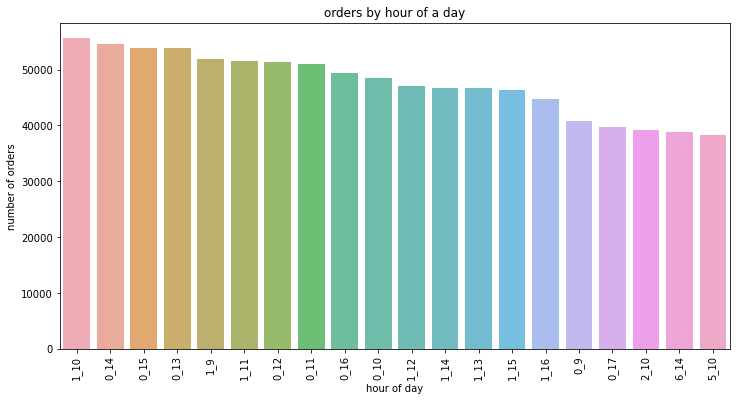

In [12]:
orders_by_hourAndDay.rename(columns={'order_id':'order_count'},inplace=True)
orders_by_hourAndDay['day_and_hour']= orders_by_hourAndDay['order_dow'].astype(str)+'_'+orders_by_hourAndDay['order_hour_of_day'].astype(str)
print(orders_by_hourAndDay.head(10))
plt.figure(figsize=(12,6))
orders_by_hourAndDay.sort_values('order_count', ascending=False, inplace=True)
sns.barplot(orders_by_hourAndDay['day_and_hour'][:20],orders_by_hourAndDay['order_count'][:20], order=orders_by_hourAndDay['day_and_hour'][:20], alpha=0.8)
plt.xlabel('hour of day')
plt.ylabel('number of orders')
plt.title('orders by hour of a day')
plt.xticks(rotation='vertical')
plt.show()

As we can see in above plot, with '0' being saturday and '1' being sunday, most number of orders happen at 10 AM on Sunday. 2nd highest orders is on 2 PM on Saturday. So, the individual time and days plot for most orders is same when combined. On Weekends from 10 AM to 4 PM we can safely assume most of our orders. 

In [7]:
# Analysis of days_since_prior_order
orders_cleaned= orders[orders['days_since_prior_order'].notnull()] #https://stackoverflow.com/a/41337493/6868740
len(orders_cleaned)

3214874

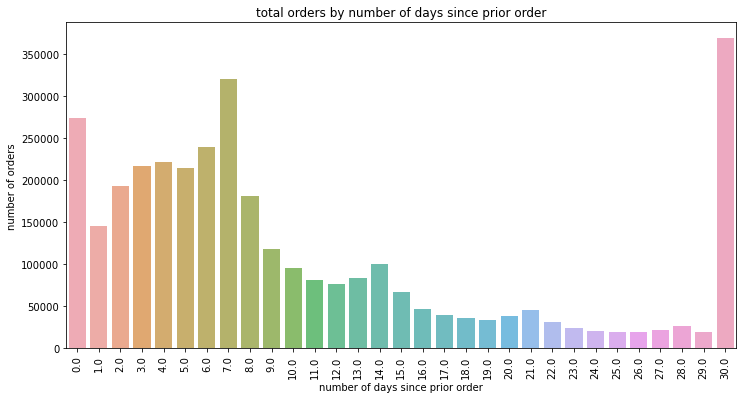

In [13]:
orders_by_days_prior_order= orders.groupby('days_since_prior_order')['order_id'].count()
plt.figure(figsize=(12,6))
sns.barplot(orders_by_days_prior_order.index, orders_by_days_prior_order.values, alpha=0.8)
plt.xlabel('number of days since prior order')
plt.ylabel('number of orders')
plt.title('total orders by number of days since prior order')
plt.xticks(rotation='vertical')
plt.show()

In above plot we can see that most reorders happen at 7th day i.e a week. Apart from that 1,2,3,4,5,6,8 days also has fair amount of reorders. One thing to notice is that at 30th day we see a large number of reorders i.e a month, and it is the largest value means cut off day to represent number of days since prior order is 30 and number of days greater than 30 is also added in the same 30th day. This explains the huge number of reorders on 30th day.

### No. of products per order

In [14]:
products_per_order= orders_products_prior.groupby('order_id')['add_to_cart_order'].max().reset_index()
products_per_order= products_per_order['add_to_cart_order'].value_counts()
products_per_order_100= products_per_order.sort_values(ascending=False)[:100]
print(products_per_order_100.head(100))
print("")
print('Median no. of products in an order is ', orders_products_prior.groupby('order_id')['add_to_cart_order'].max().median())

5      228330
6      227675
4      222081
7      220006
3      207027
        ...  
102         3
96          3
99          2
101         2
104         2
Name: add_to_cart_order, Length: 100, dtype: int64

Median no. of products in an order is  8.0


#### Now we will merge our order_products_prior with the products, aisles and department dataframe

In [5]:
orders_with_order_products= pd.merge(orders, orders_products_prior, on='order_id', how='inner')
orders_with_order_products= pd.merge(orders_with_order_products, products, on='product_id', how='left')
orders_with_order_products= pd.merge(orders_with_order_products, departments, on='department_id', how='left')
orders_with_order_products= pd.merge(orders_with_order_products, aisles, on='aisle_id', how='left')
#  check for null or duplicate values.
with open('orders_with_order_products.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

#### Check for null values in our new dataframe

In [3]:
orders_with_order_products.isnull().any()

order_id                  False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order    False
product_id                False
add_to_cart_order         False
reordered                 False
product_name              False
aisle_id                  False
department_id             False
department                False
aisle                     False
dtype: bool

#### Check for duplicates

In [4]:
orders_with_order_products.duplicated().any()

False

### Let us check which department has highest orders

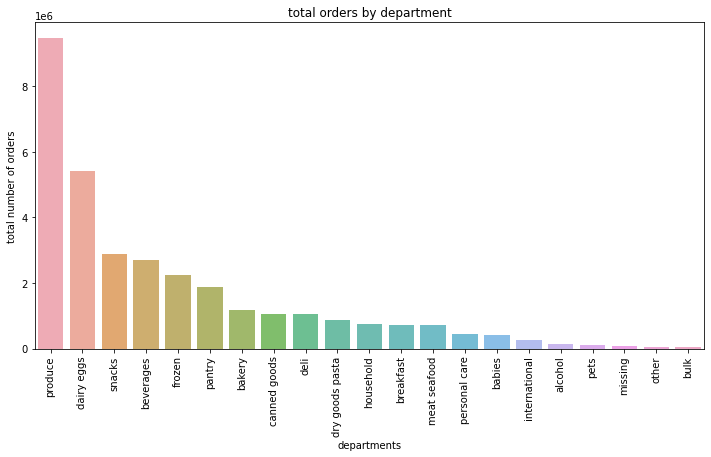

In [5]:
department_wise_orders= orders_with_order_products['department'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(department_wise_orders.index, department_wise_orders.values, alpha=0.8)
plt.xlabel('departments')
plt.ylabel('total number of orders')
plt.title('total orders by department')
plt.xticks(rotation='vertical')
plt.show()


In above plot we can see that produce department (which contains products like vegetables and fruits) is ordered highest, which explains it as essentials. Dairy eggs is ordered next highest. 

### Similarily check which aisles has highest orders.

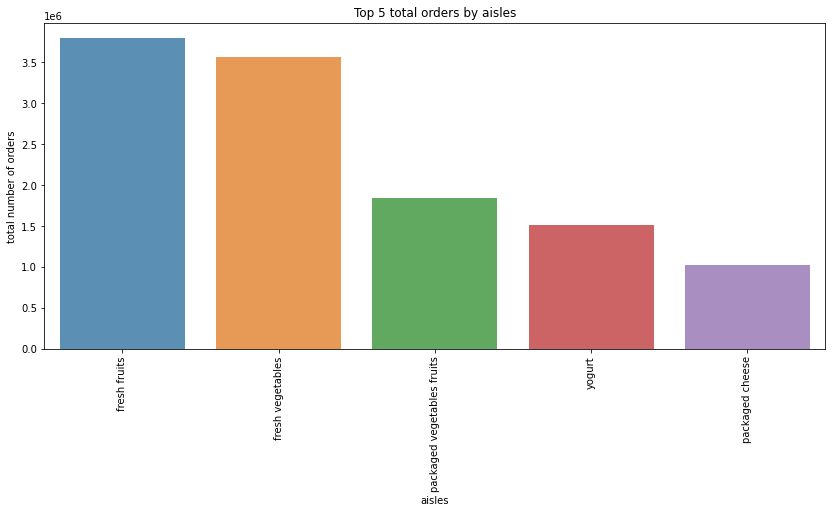

In [16]:
aisles_wise_orders= orders_with_order_products['aisle'].value_counts()[:5]
plt.figure(figsize=(14,6))
sns.barplot(aisles_wise_orders.index, aisles_wise_orders.values, alpha=0.8)
plt.xlabel('aisles')
plt.ylabel('total number of orders')
plt.title('Top 5 total orders by aisles')
plt.xticks(rotation='vertical')
plt.show()

Fresh fruits, Fresh vegetables, Packaged vegetables fruits, Yogurt, packaged cheese are top 5 aisles from which highest orders are made. It also explains why produce and Dairy eggs departments was with highest orders.

Banana                      491291
Bag of Organic Bananas      394930
Organic Strawberries        275577
Organic Baby Spinach        251705
Organic Hass Avocado        220877
Organic Avocado             184224
Large Lemon                 160792
Strawberries                149445
Limes                       146660
Organic Whole Milk          142813
Organic Raspberries         142603
Organic Yellow Onion        117716
Organic Garlic              113936
Organic Zucchini            109412
Organic Blueberries         105026
Cucumber Kirby               99728
Organic Fuji Apple           92889
Organic Lemon                91251
Organic Grape Tomatoes       88078
Apple Honeycrisp Organic     87272
Name: product_name, dtype: int64


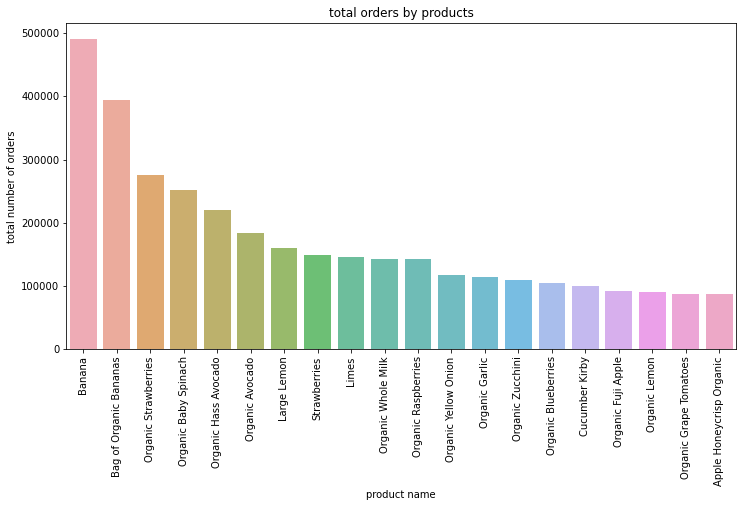

In [30]:
# Now let's check which product is ordered the most.
products_wise_order= orders_with_order_products['product_name'].value_counts()
products_wise_order= products_wise_order[:20]
print(products_wise_order)
plt.figure(figsize=(12,6))
sns.barplot(products_wise_order.index, products_wise_order.values, alpha=0.8)
plt.xlabel('product name')
plt.ylabel('total number of orders')
plt.title('total orders by products')
plt.xticks(rotation='vertical')
plt.show()



Bananas is ordered highest among all products. Followed by Bag of organic bananas which is also bananas.

### Now we will analyze reordered data

#### reorders w.r.t user

In [4]:
with open('orders_with_order_products.pkl', 'rb') as f:
    orders_with_order_products = pkl.load(f)


In [6]:
#this can also be used as a new feature i.e reorder count of a user
reorders_user= orders_with_order_products.groupby('user_id')['reordered'].sum().reset_index()
reorders_user.head()

# show  top reorder count 

,user_id,reordered
0,1,41
1,2,93
2,3,55
3,4,1
4,5,14


#### Top 20 reorders count w.r.t users

In [7]:
reorders_user= reorders_user.sort_values(by=['reordered'], ascending=False)[:20]
reorders_user.head(20)

,user_id,reordered
201267,201268,3275
129927,129928,3167
164054,164055,2657
137628,137629,2619
186703,186704,2553
108186,108187,2446
176477,176478,2429
33730,33731,2397
57545,57546,2280
17737,17738,2227


#### reorders w.r.t products (which products are reordered most

In [8]:
reorders_products= orders_with_order_products.groupby('product_name')['reordered'].sum().reset_index()
reorders_products.head()

,product_name,reordered
0,#2 Coffee Filters,257
1,#2 Cone White Coffee Filters,3
2,#2 Mechanical Pencils,0
3,#4 Natural Brown Coffee Filters,89
4,& Go! Hazelnut Spread + Pretzel Sticks,87


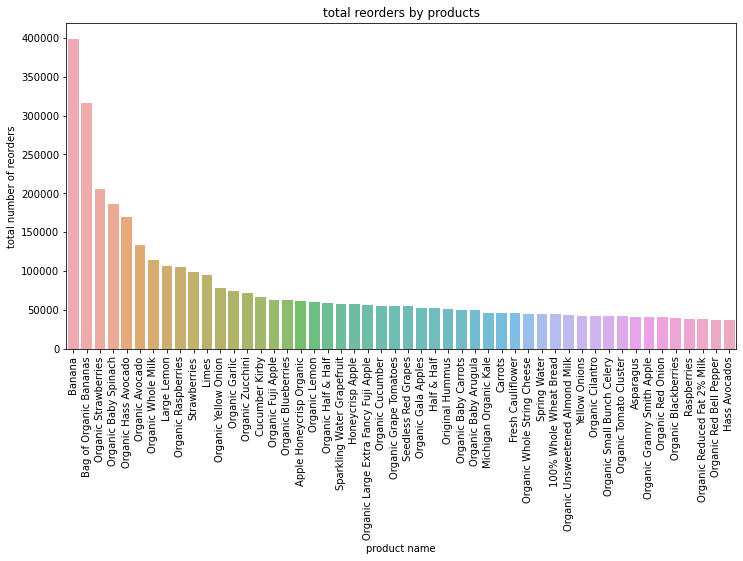

In [9]:
reorders_products= reorders_products.sort_values(by=['reordered'], ascending=False)[:50]
plt.figure(figsize=(12,6))
sns.barplot(reorders_products['product_name'], reorders_products['reordered'], alpha=0.8)
plt.xlabel('product name')
plt.ylabel('total number of reorders')
plt.title('total reorders by products')
plt.xticks(rotation='vertical')
plt.show()

Most number of reorders are similar to most number of orders. This explains reorders are huge chunk in orders data.
We will verify that below also.

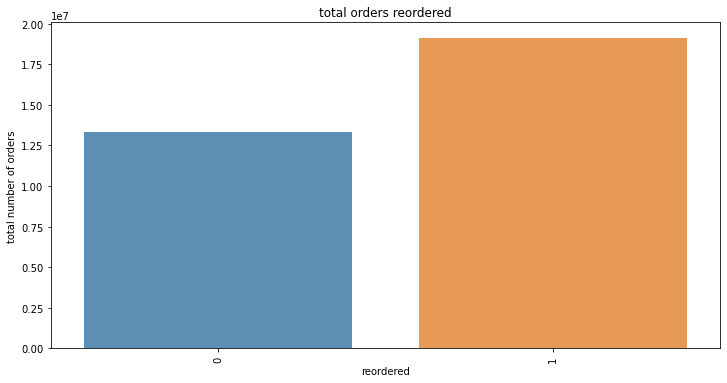

In [10]:
reorders= orders_with_order_products['reordered'].value_counts()
plt.figure(figsize=(12,6))
sns.barplot(reorders.index, reorders.values, alpha=0.8)
plt.xlabel('reordered')
plt.ylabel('total number of orders')
plt.title('total orders reordered')
plt.xticks(rotation='vertical')
plt.show()

In [11]:
print('Total no. of 1st time order =', reorders[0])
print('Total no. of reorders =', reorders[1])

Total no. of 1st time order = 13307953
Total no. of reorders = 19126536


#### Reorders with respect to departments

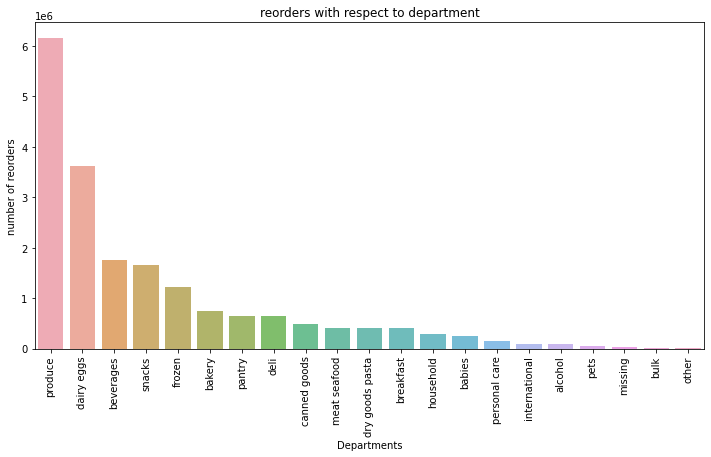

In [12]:
reorders_department_average= orders_with_order_products.groupby('department')['reordered'].sum()
reorders_department_average= reorders_department_average.sort_values( ascending=False)
plt.figure(figsize=(12,6))
sns.barplot(reorders_department_average.index, reorders_department_average.values, alpha=0.8)
plt.xlabel('Departments')
plt.ylabel('number of reorders')
plt.title('reorders with respect to department')
plt.xticks(rotation='vertical')
plt.show()

Here also Produce department has highest number of reorders followed by Dairy eggs. Similar to number of orders.

In [3]:
with open('reorders_user_average.pkl', 'rb') as f:
    reorders_user_average= pkl.load(f)

#### Based on above EDA we will create some new features and add it to our dataset before doing univariate and bivariate analysis of our features.

In [13]:
# Number of orders for each user 
# https://www.geeksforgeeks.org/get-unique-values-from-a-column-in-pandas-dataframe/
number_of_orders = orders_with_order_products.groupby('user_id')['order_id'].nunique().reset_index()
number_of_orders.rename(columns={'order_id':'num_orders'},inplace=True)
number_of_orders.head()

# percentage 

,user_id,num_orders
0,1,10
1,2,14
2,3,12
3,4,5
4,5,4


In [14]:
orders_with_order_products= pd.merge(orders_with_order_products, number_of_orders, on='user_id', how='left')
del number_of_orders

In [15]:
# This will be used to calculate a new order_importance feature.
# Number of products within each order

order_length = orders_with_order_products.groupby('order_id').size().reset_index()
order_length.rename(columns={0:'order_length'},inplace=True)
order_length.head()

,order_id,order_length
0,2,9
1,3,8
2,4,13
3,5,26
4,6,3


In [16]:
orders_with_order_products= pd.merge(orders_with_order_products, order_length, on='order_id', how='left')
del order_length

In [18]:
# https://www.kaggle.com/winstonchan1990/baseline-model
# order importance = order_number/num_orders
# More recent orders have more weight
orders_with_order_products['order_importance'] = orders_with_order_products['order_number']/orders_with_order_products['num_orders']

In [19]:
# product importance = (order_length-add_to_cart_order+1)/order_length
# Assign more importance to products that are added earlier to the cart for each order

orders_with_order_products['product_importance'] = (orders_with_order_products['order_length']-orders_with_order_products['add_to_cart_order']+1)/orders_with_order_products['order_length']

In [20]:
# importance_score = product_importance * order_importance
# for each product-order pair

orders_with_order_products['importance_score'] = orders_with_order_products['product_importance']*orders_with_order_products['order_importance']
orders_with_order_products.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,department,aisle,num_orders,order_length,order_importance,product_importance,importance_score
0,2539329,1,prior,1,2,8,0.0,196,1,0,Soda,77,7,beverages,soft drinks,10,5,0.1,1.000000,0.100000
1,2539329,1,prior,1,2,8,0.0,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91,16,dairy eggs,soy lactosefree,10,5,0.1,0.800000,0.080000
2,2539329,1,prior,1,2,8,0.0,12427,3,0,Original Beef Jerky,23,19,snacks,popcorn jerky,10,5,0.1,0.600000,0.060000
3,2539329,1,prior,1,2,8,0.0,26088,4,0,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky,10,5,0.1,0.400000,0.040000
4,2539329,1,prior,1,2,8,0.0,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54,17,household,paper goods,10,5,0.1,0.200000,0.020000
5,2398795,1,prior,2,3,7,15.0,196,1,1,Soda,77,7,beverages,soft drinks,10,6,0.2,1.000000,0.200000
6,2398795,1,prior,2,3,7,15.0,10258,2,0,Pistachios,117,19,snacks,nuts seeds dried fruit,10,6,0.2,0.833333,0.166667
7,2398795,1,prior,2,3,7,15.0,12427,3,1,Original Beef Jerky,23,19,snacks,popcorn jerky,10,6,0.2,0.666667,0.133333
8,2398795,1,prior,2,3,7,15.0,13176,4,0,Bag of Organic Bananas,24,4,produce,fresh fruits,10,6,0.2,0.500000,0.100000
9,2398795,1,prior,2,3,7,15.0,26088,5,1,Aged White Cheddar Popcorn,23,19,snacks,popcorn jerky,10,6,0.2,0.333333,0.066667


In [24]:
with open('orders_with_order_products_new10.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [4]:
with open('orders_with_order_products_new10.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [21]:
with open('orders_with_order_products_new1.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products_new1.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [3]:
# sum up the importance_scores for each product_id for each user_id
# This feature will be most important feature as it gives a sum of all importance score based on a user and product unique combination. 
df_importance = orders_with_order_products.groupby(['user_id','product_id'])['importance_score'].sum().reset_index()
df_importance.rename(columns={'importance_score':'importance_score_sum'},inplace=True)
df_importance.head(10)


,user_id,product_id,importance_score_sum
0,1,196,4.916667
1,1,10258,3.099444
2,1,10326,0.250000
3,1,12427,3.121944
4,1,13032,0.395556
5,1,13176,0.162500
6,1,14084,0.080000
7,1,17122,0.187500
8,1,25133,2.578056
9,1,26088,0.106667


In [4]:
orders_with_order_products= pd.merge(orders_with_order_products,df_importance, on=['user_id','product_id'],how='left')
 
orders_with_order_products.head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,aisle_id,department_id,department,aisle,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum
0,2539329,1,prior,1,2,8,0.0,196,1,0,...,77,7,beverages,soft drinks,10,5,0.1,1.000000,0.100000,4.916667
1,2539329,1,prior,1,2,8,0.0,14084,2,0,...,91,16,dairy eggs,soy lactosefree,10,5,0.1,0.800000,0.080000,0.080000
2,2539329,1,prior,1,2,8,0.0,12427,3,0,...,23,19,snacks,popcorn jerky,10,5,0.1,0.600000,0.060000,3.121944
3,2539329,1,prior,1,2,8,0.0,26088,4,0,...,23,19,snacks,popcorn jerky,10,5,0.1,0.400000,0.040000,0.106667
4,2539329,1,prior,1,2,8,0.0,26405,5,0,...,54,17,household,paper goods,10,5,0.1,0.200000,0.020000,0.100000
5,2398795,1,prior,2,3,7,15.0,196,1,1,...,77,7,beverages,soft drinks,10,6,0.2,1.000000,0.200000,4.916667
6,2398795,1,prior,2,3,7,15.0,10258,2,0,...,117,19,snacks,nuts seeds dried fruit,10,6,0.2,0.833333,0.166667,3.099444
7,2398795,1,prior,2,3,7,15.0,12427,3,1,...,23,19,snacks,popcorn jerky,10,6,0.2,0.666667,0.133333,3.121944
8,2398795,1,prior,2,3,7,15.0,13176,4,0,...,24,4,produce,fresh fruits,10,6,0.2,0.500000,0.100000,0.162500
9,2398795,1,prior,2,3,7,15.0,26088,5,1,...,23,19,snacks,popcorn jerky,10,6,0.2,0.333333,0.066667,0.106667


In [7]:
with open('orders_with_order_products_new11.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products_new11.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [5]:
with open('orders_with_order_products_new2.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products_new2.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [3]:
#number of reorders of a user. This also is used as a new feature.
reorders_user= orders_with_order_products.groupby('user_id')['reordered'].sum().reset_index()
reorders_user.head()
reorders_user.columns= ['user_id', 'reordered_count']


In [4]:

# dropping columns which are no longer useful because these information is within department_id, aisle_id, product_id respectively
orders_with_order_products= orders_with_order_products.drop(['department', 'aisle', 'eval_set','product_name'], axis=1)
import gc
gc.collect()

0

In [5]:
import gc
orders_with_order_products= pd.merge(orders_with_order_products, reorders_user, on='user_id', how='left')
del reorders_user
gc.collect()

22

In [6]:
# Ratio of reorders of each user. Can also be used as a new feature
reorders_user_average= orders_with_order_products.groupby('user_id')['reordered'].mean().reset_index()
reorders_user_average.rename(columns={'reordered':'reorder_ratio'},inplace=True)

reorders_user_average.head()

# Add this also as a feature

,user_id,reorder_ratio
0,1,0.694915
1,2,0.476923
2,3,0.625000
3,4,0.055556
4,5,0.378378


In [7]:

orders_with_order_products= pd.merge(orders_with_order_products, reorders_user_average, on='user_id', how='left')
del reorders_user_average
gc.collect()

22

In [8]:
orders_with_order_products.head()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum,reordered_count,reorder_ratio
0,2539329,1,1,2,8,0.0,196,1,0,77,7,10,5,0.1,1.0,0.10,4.916667,41,0.694915
1,2539329,1,1,2,8,0.0,14084,2,0,91,16,10,5,0.1,0.8,0.08,0.080000,41,0.694915
2,2539329,1,1,2,8,0.0,12427,3,0,23,19,10,5,0.1,0.6,0.06,3.121944,41,0.694915
3,2539329,1,1,2,8,0.0,26088,4,0,23,19,10,5,0.1,0.4,0.04,0.106667,41,0.694915
4,2539329,1,1,2,8,0.0,26405,5,0,54,17,10,5,0.1,0.2,0.02,0.100000,41,0.694915


In [9]:
with open('orders_with_order_products_new4.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products_new4.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [10]:
orders_with_order_products.head()


,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,aisle_id,department_id,num_orders,order_length,order_importance,product_importance,importance_score,importance_score_sum,reordered_count,reorder_ratio
0,2539329,1,1,2,8,0.0,196,1,0,77,7,10,5,0.1,1.0,0.10,4.916667,41,0.694915
1,2539329,1,1,2,8,0.0,14084,2,0,91,16,10,5,0.1,0.8,0.08,0.080000,41,0.694915
2,2539329,1,1,2,8,0.0,12427,3,0,23,19,10,5,0.1,0.6,0.06,3.121944,41,0.694915
3,2539329,1,1,2,8,0.0,26088,4,0,23,19,10,5,0.1,0.4,0.04,0.106667,41,0.694915
4,2539329,1,1,2,8,0.0,26405,5,0,54,17,10,5,0.1,0.2,0.02,0.100000,41,0.694915


In [4]:
Y= orders_with_order_products['reordered']
orders_with_order_products= orders_with_order_products.drop('reordered', axis=1)

In [5]:
with open('X.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)
with open('Y.pkl', 'wb') as f:
    pkl.dump(Y,f)

In [2]:
with open('X.pkl', 'rb') as f:
    X= pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y= pkl.load(f)

### Univariate analysis w.r.t each feature.

#### order_dow

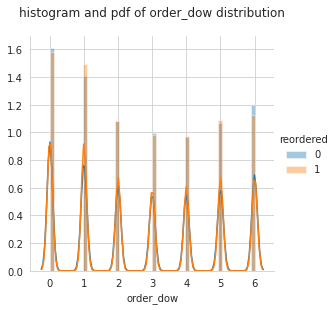

In [14]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"order_dow").add_legend()
plt.title('histogram and pdf of order_dow distribution',pad=20)
plt.show()

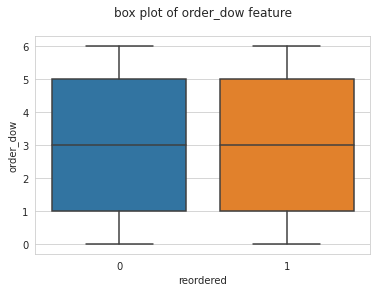

In [51]:
sns.boxplot(x='reordered',y='order_dow',data= orders_with_order_products) 
plt.title('box plot of order_dow feature',pad=20)
plt.show()

We cannot see any difference in reordered status with this feature

#### num_orders

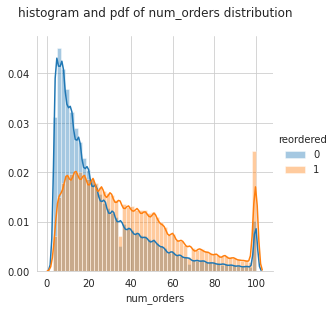

In [56]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"num_orders").add_legend()
plt.title('histogram and pdf of num_orders distribution',pad=20)
plt.show()

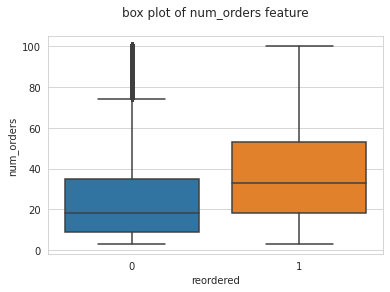

In [54]:
sns.boxplot(x='reordered',y='num_orders',data= orders_with_order_products) 
plt.title('box plot of num_orders feature',pad=20)
plt.show()

In num_orders feature we can definitly see values which favour reordered or not. IQR range of num_orders where product is not reordered is in range 10 to 35. Whereas, IQR range for reordered products is from 19 to 47. Therefore, we can infer that higher num_orders value i.e a user's total orders are high then chances of reorders are high.

#### add_to_cart_order

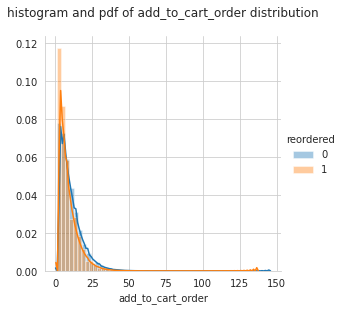

In [33]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"add_to_cart_order").add_legend()
plt.title('histogram and pdf of add_to_cart_order distribution',pad=20)
plt.show()

Histogram and PDF of age. Here Histogram on add_to_cart_order is not helping in determining reordered status of a product as both pdf are overlapping.


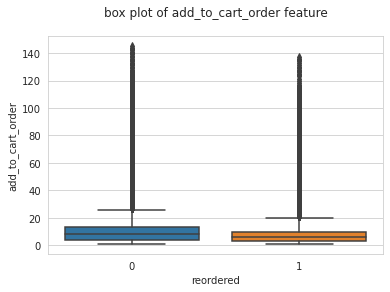

In [36]:
# Remove outliers i.e above 90th perecntile.


sns.boxplot(x='reordered',y='add_to_cart_order',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of add_to_cart_order feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

In above boxplot we can interpret that 75th percentile is around 10 (i.e 75% points are below 10). Therefore, most of the products which are not reorderd are having high no. at add_to_cart_order as compared to products reordered w.r.t a user.

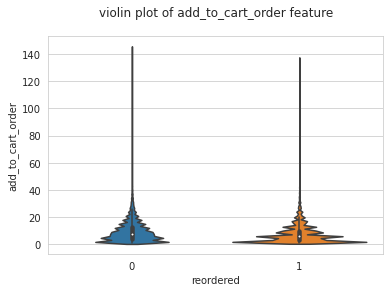

In [37]:
sns.violinplot(x="reordered",y="add_to_cart_order",data=orders_with_order_products)
plt.title('violin plot of add_to_cart_order feature',pad=20)
plt.show()

This plot is proving the above point mentioned in box plot. We can see that the density or number of datapoints in reordered are more with low add_to_cart_order value (i.e products which are added 1st to cart). 

#### days_since_prior_order

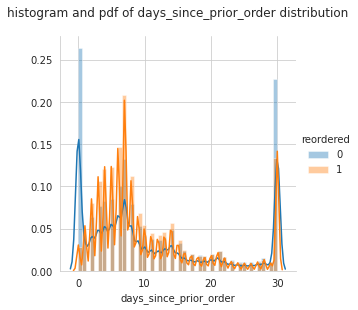

In [38]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"days_since_prior_order").add_legend()
plt.title('histogram and pdf of days_since_prior_order distribution',pad=20)
plt.show()

Most of the points are overlapping but we can also observe that points 'not reordered' are having high number of datapoints near 0 value of days_since_prior_order. 
Also values between 1 to 10 in this feature has more number of datapoints when reordered.

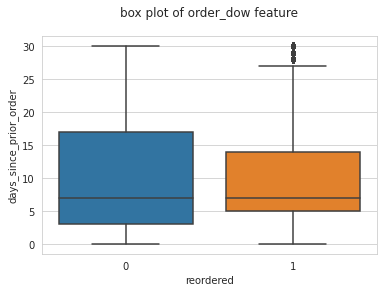

In [4]:
sns.boxplot(x='reordered',y='days_since_prior_order',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of days_since_prior_order feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

In this box plot also we can see that reordered datapoint's value has less range between IQR. Although median or 50th percentile is same.

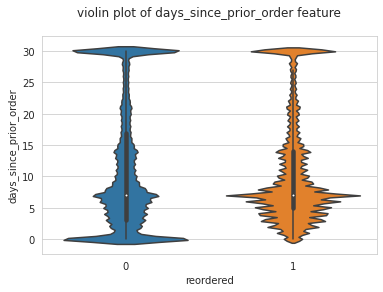

In [5]:
sns.violinplot(x="reordered",y="days_since_prior_order",data=orders_with_order_products)
plt.title('violin plot of days_since_prior_order feature',pad=20)
plt.show()

This violin plot proves the above point in pdf plot that '0' value has high number of datapoints when 'not reordered'. Also there are high number of reordered datapoints near value 7 for this feature.

#### Department ID

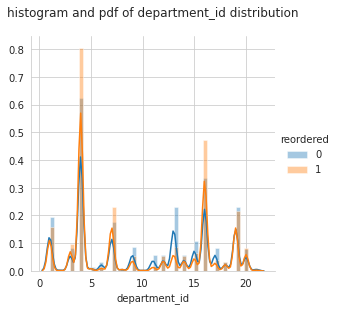

In [9]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"department_id").add_legend()
plt.title('histogram and pdf of department_id distribution',pad=20)
plt.show()

Nothing is clear from the above pdf plot. Let's try with box plot.

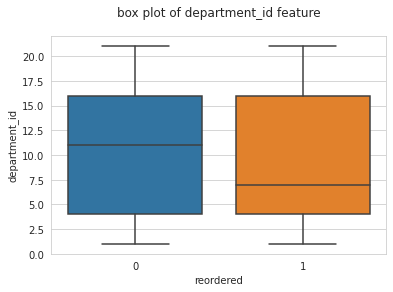

In [10]:
sns.boxplot(x='reordered',y='department_id',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of department_id feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

Here we can see that pdf or box plots are not very helpful in giving any insights as department_id is not a decesive feature. Only couple of departments are having products which are reordered many times. Thus, those department's id will be helpful in giving weightage to classifying products reordered or not.

#### Aisle id

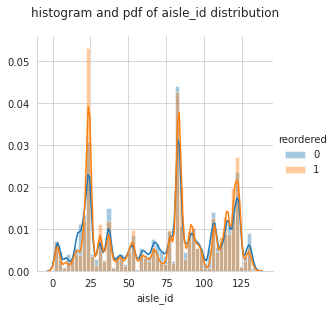

In [13]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"aisle_id").add_legend()
plt.title('histogram and pdf of aisle_id distribution',pad=20)
plt.show()

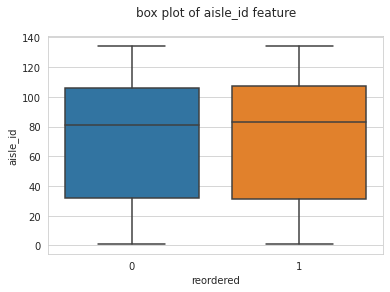

In [14]:
sns.boxplot(x='reordered',y='aisle_id',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of aisle_id feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

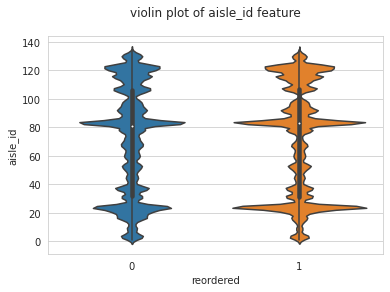

In [15]:
sns.violinplot(x="reordered",y="aisle_id",data=orders_with_order_products)
plt.title('violin plot of aisle_id feature',pad=20)
plt.show()

In all three above plots, we can't derive any valuable insights. Therefore, we can discard this feature if we want. Let's decide that later.  

####  Order Importance

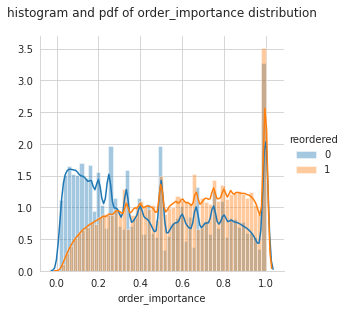

In [16]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"order_importance").add_legend()
plt.title('histogram and pdf of order_importance distribution',pad=20)
plt.show()

In the above pdf plot we can see that curves are un-overlapped than other features' graph. Here, when order_importance is low, we see a denser graph for 'not reordered' and opposite for 'ordered'.

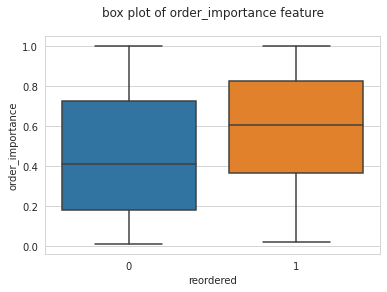

In [17]:
sns.boxplot(x='reordered',y='order_importance',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of order_importance feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

In above plot also we can observe that IQR range(Inter Quantile Range. 25th to 75th percentile) of order_importance is higher for reordered products.

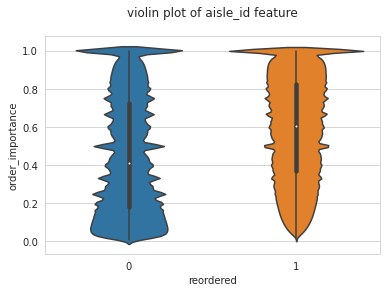

In [28]:
sns.violinplot(x="reordered",y="order_importance",data=orders_with_order_products)
plt.title('violin plot of aisle_id feature',pad=20)
plt.show()

Here also density of 'not reordered' is more when order_importance is low.

#### Product Importance

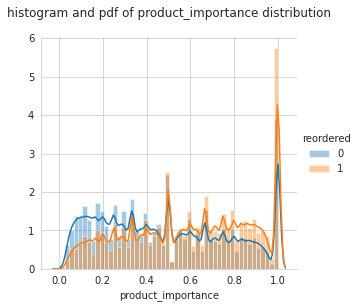

In [40]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"product_importance").add_legend()
plt.title('histogram and pdf of product_importance distribution',pad=20)
plt.show()

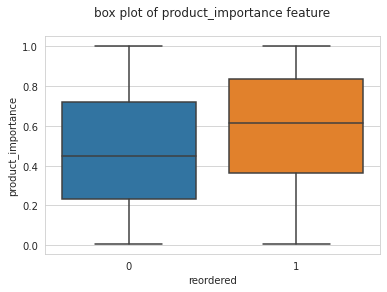

In [20]:
sns.boxplot(x='reordered',y='product_importance',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of product_importance feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

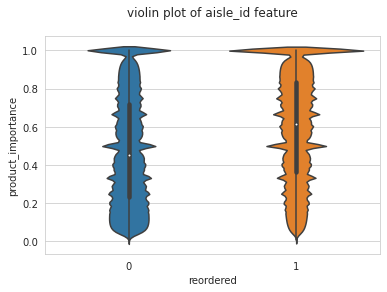

In [29]:
sns.violinplot(x="reordered",y="product_importance",data=orders_with_order_products)
plt.title('violin plot of aisle_id feature',pad=20)
plt.show()

'product_importance' feature is affecting reordered label similar to 'order_importance' as plots is same for both.

#### Importance score

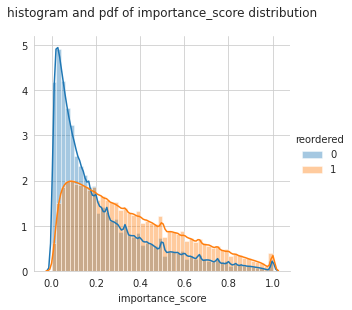

In [22]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"importance_score").add_legend()
plt.title('histogram and pdf of importance_score distribution',pad=20)
plt.show()

Here also we can see 'not reordered' product having high density when importance_score is low.

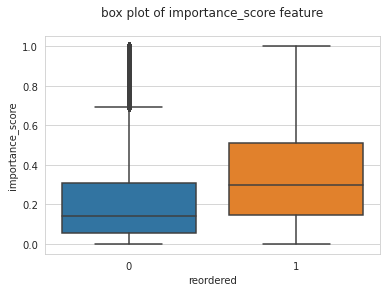

In [23]:
sns.boxplot(x='reordered',y='importance_score',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of importance_score feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

The IRQ range is on higher side i.e. 0.18 to 0.5 for products reordered. Whereas IQR for 'not reordered' products are on the lower range i.e. 0.02 to 0.3.

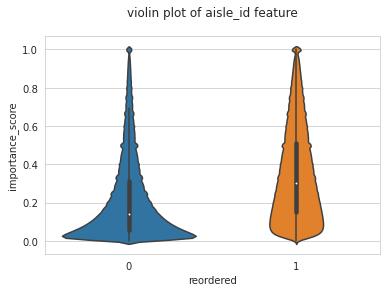

In [30]:
sns.violinplot(x="reordered",y="importance_score",data=orders_with_order_products)
plt.title('violin plot of aisle_id feature',pad=20)
plt.show()

In above violin plot also we could see that density of points is higher when importance_score value is near 0.

#### importance_score_sum

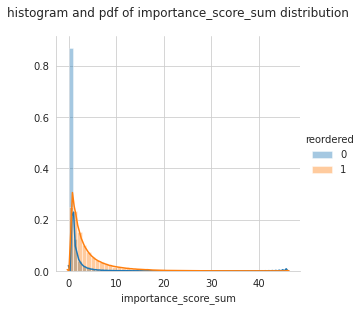

In [24]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"importance_score_sum").add_legend()
plt.title('histogram and pdf of importance_score_sum distribution',pad=20)
plt.show()

Nothing much can be inferred from the above plot.

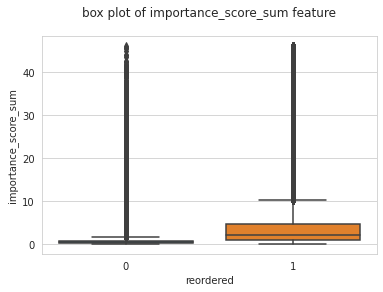

In [25]:
sns.boxplot(x='reordered',y='importance_score_sum',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of importance_score_sum feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

The above box plot of importance_score gives a very explanation of product reordered or not. We can see that IQR of feature w.r.t 'not reordered' is in very less range (0 - 1). Whereas the IQR for feature w.r.t 'ordered' is 0 to 6. 100th percentile is also in range of 0 to 0.2 for 'not ordered' and 0 to 10 for ordered.   

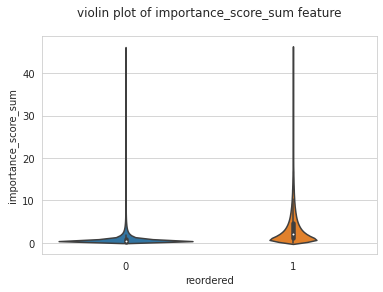

In [31]:
sns.violinplot(x="reordered",y="importance_score_sum",data=orders_with_order_products)
plt.title('violin plot of importance_score_sum feature',pad=20)
plt.show()

In above violin plot also we can see a very high density at value 0 of importance_score feature for 'not reordered' label.

#### reordered_count

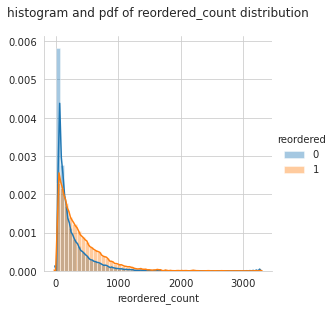

In [42]:
plt.close()
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products,hue="reordered",height=4).map(sns.distplot,"reordered_count").add_legend()
plt.title('histogram and pdf of reordered_count distribution',pad=20)
plt.show()

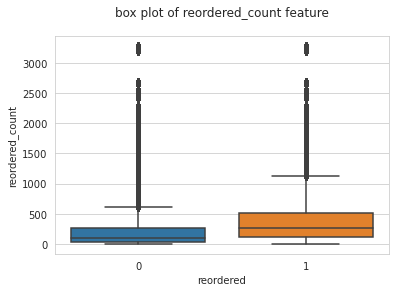

In [27]:
sns.boxplot(x='reordered',y='reordered_count',data= orders_with_order_products) # we are taking axil_node feature bcoz we saw it was most interpretable.
plt.title('box plot of reordered_count feature',pad=20)
plt.show()
# sns.boxplot(x='reordered',y='order_dow',data= df) # we are taking axil_node feature bcoz we saw it was most interpretable.
# plt.title('box plot of age feature',pad=20)
# plt.show()

In above plot the IQR of 'reordered_count' for reordered is from around 100 to 600 value. Whereas, for 'not reordered' is from around 20 to 250  value. 

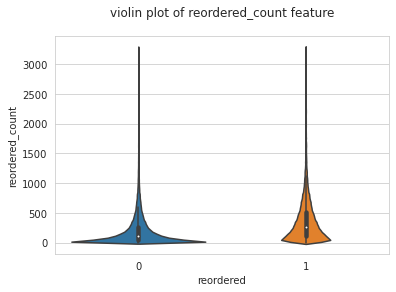

In [32]:
sns.violinplot(x="reordered",y="reordered_count",data=orders_with_order_products)
plt.title('violin plot of reordered_count feature',pad=20)
plt.show()

The above three plots for reordered_count is also similar to importance_score feature i.e low value in reordered_count has most density as 'not reordered'.

### Bi-variate analysis

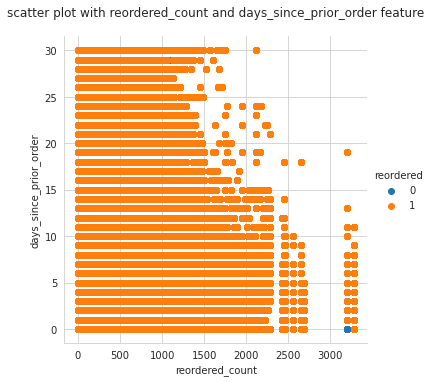

In [45]:
#color points based on class labels suing seaborn
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products, hue='reordered',height=5).map(plt.scatter,"reordered_count","days_since_prior_order").add_legend()
plt.title("scatter plot with reordered_count and days_since_prior_order feature",pad=20)
plt.show()

Can't tell much about this plot because we can only see reordered data with reordered_count and days_since_prior_order.

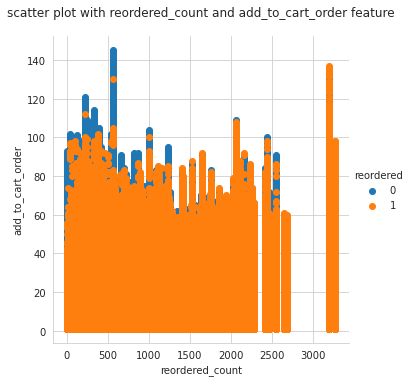

In [47]:
#color points based on class labels suing seaborn
sns.set_style("whitegrid")
sns.FacetGrid(orders_with_order_products, hue='reordered',height=5).map(plt.scatter,"reordered_count","add_to_cart_order").add_legend()
plt.title("scatter plot with reordered_count and add_to_cart_order feature",pad=20)
plt.show()

No clear seperation between reordered count and add_to_car_order

Most of the bivariate analysis like contour plots doesn't give any meaningful insights.

#### Conclusion
1. We can drop some features like aisle_id, order_hour_of_day, order_dow as they are not much helpful in predicting reordered, but we will keep then as number of features are not more in number.
2. Rest features are helpful in predicting reorders as higher values in those features tend to be reordered more.

In [2]:
with open('X.pkl', 'rb') as f:
    X= pkl.load(f)
with open('Y.pkl', 'rb') as f:
    Y= pkl.load(f)

In [3]:
X.shape

(32705973, 18)

In [11]:
# removing useless features. We need only user related with each product for each order.
orders_with_order_products = orders_with_order_products.drop(['days_since_prior_order', 'order_id','order_number', 'order_dow', 'order_hour_of_day',
                                                             'add_to_cart_order', 'aisle_id', 'order_importance',
                                                             'product_importance', 'importance_score', 'reordered'], axis=1) 
orders_with_order_products.head()

,user_id,product_id,department_id,num_orders,order_length,importance_score_sum,reordered_count,reorder_ratio
0,1,196,7,10,5,4.916667,41,0.694915
1,1,14084,16,10,5,0.080000,41,0.694915
2,1,12427,19,10,5,3.121944,41,0.694915
3,1,26088,19,10,5,0.106667,41,0.694915
4,1,26405,17,10,5,0.100000,41,0.694915


In [12]:
mean_order_len_user = orders_with_order_products.groupby('user_id')['order_length'].mean().reset_index()
mean_order_len_user.rename(columns={'order_length':'mean_order_length_user'},inplace=True)
mean_order_len_user.head()

,user_id,mean_order_length_user
0,1,6.254237
1,2,16.107692
2,3,7.886364
3,4,4.555556
4,5,10.027027


In [13]:
orders_with_order_products= orders_with_order_products.merge(mean_order_len_user, on='user_id', how='left')
orders_with_order_products.head()

,user_id,product_id,department_id,num_orders,order_length,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,1,196,7,10,5,4.916667,41,0.694915,6.254237
1,1,14084,16,10,5,0.080000,41,0.694915,6.254237
2,1,12427,19,10,5,3.121944,41,0.694915,6.254237
3,1,26088,19,10,5,0.106667,41,0.694915,6.254237
4,1,26405,17,10,5,0.100000,41,0.694915,6.254237


In [14]:
orders_with_order_products= orders_with_order_products.drop(['order_length'], axis=1)
orders_with_order_products= orders_with_order_products.drop_duplicates()
orders_with_order_products.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,1,196,7,10,4.916667,41,0.694915,6.254237
1,1,14084,16,10,0.080000,41,0.694915,6.254237
2,1,12427,19,10,3.121944,41,0.694915,6.254237
3,1,26088,19,10,0.106667,41,0.694915,6.254237
4,1,26405,17,10,0.100000,41,0.694915,6.254237


In [7]:
with open('orders_with_order_products_new50.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products_new50.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [15]:
with open('orders_with_order_products_new5.pkl', 'wb') as f:
    pkl.dump(orders_with_order_products,f)

In [2]:
with open('orders_with_order_products_new5.pkl', 'rb') as f:
    orders_with_order_products= pkl.load(f)

In [3]:
orders_with_order_products.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,1,196,7,10,4.916667,41,0.694915,6.254237
1,1,14084,16,10,0.080000,41,0.694915,6.254237
2,1,12427,19,10,3.121944,41,0.694915,6.254237
3,1,26088,19,10,0.106667,41,0.694915,6.254237
4,1,26405,17,10,0.100000,41,0.694915,6.254237


In [4]:
num_unique_user= orders_with_order_products['user_id'].nunique()
num_unique_user

206209

In [19]:
# X_sampled_indexes= X.sample(n= 8000000).index
# print(X_sampled_indexes)

In [9]:
# X_sampled= X.loc[X_sampled_indexes]
# Y_sampled= Y.loc[X_sampled_indexes]

In [10]:
# with open('X_sampled.pkl', 'wb') as f:
#     pkl.dump(X_sampled,f)
# with open('Y_sampled.pkl', 'wb') as f:
#     pkl.dump(Y_sampled,f)

In [2]:
# with open('X_sampled.pkl', 'rb') as f:
#     X_sampled= pkl.load(f)
# with open('Y_sampled.pkl', 'rb') as f:
#     Y_sampled= pkl.load(f)

In [5]:
orders_with_order_products.shape

(13307953, 8)

In [6]:
orders_with_order_products.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
0,1,196,7,10,4.916667,41,0.694915,6.254237
1,1,14084,16,10,0.080000,41,0.694915,6.254237
2,1,12427,19,10,3.121944,41,0.694915,6.254237
3,1,26088,19,10,0.106667,41,0.694915,6.254237
4,1,26405,17,10,0.100000,41,0.694915,6.254237


In [7]:
orders= pd.read_csv('data/orders.csv')


### Creating Train and Test data

In [8]:
orders_future = orders.loc[((orders.eval_set == 'train') | (orders.eval_set == 'test')), ['user_id', 'eval_set', 'order_id']]
orders_future.head(10)

,user_id,eval_set,order_id
10,1,train,1187899
25,2,train,1492625
38,3,test,2774568
44,4,test,329954
49,5,train,2196797
53,6,test,1528013
74,7,train,525192
78,8,train,880375
82,9,train,1094988
88,10,train,1822501


In [9]:
import gc
del orders
gc.collect()

44

In [10]:
#merging the orders_future with data.
orders_products = orders_with_order_products.merge(orders_future, on='user_id', how='left')
orders_products.head(20)
    

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,eval_set,order_id
0,1,196,7,10,4.916667,41,0.694915,6.254237,train,1187899
1,1,14084,16,10,0.080000,41,0.694915,6.254237,train,1187899
2,1,12427,19,10,3.121944,41,0.694915,6.254237,train,1187899
3,1,26088,19,10,0.106667,41,0.694915,6.254237,train,1187899
4,1,26405,17,10,0.100000,41,0.694915,6.254237,train,1187899
5,1,10258,19,10,3.099444,41,0.694915,6.254237,train,1187899
6,1,13176,4,10,0.162500,41,0.694915,6.254237,train,1187899
7,1,13032,14,10,0.395556,41,0.694915,6.254237,train,1187899
8,1,25133,16,10,2.578056,41,0.694915,6.254237,train,1187899
9,1,30450,13,10,0.060000,41,0.694915,6.254237,train,1187899


In [25]:
with open('orders_products','wb') as f:
    pkl.dump(orders_products,f) 

In [4]:
with open('orders_products','rb') as f:
    orders_products= pkl.load(f) 

In [11]:
orders_products.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,eval_set,order_id
0,1,196,7,10,4.916667,41,0.694915,6.254237,train,1187899
1,1,14084,16,10,0.080000,41,0.694915,6.254237,train,1187899
2,1,12427,19,10,3.121944,41,0.694915,6.254237,train,1187899
3,1,26088,19,10,0.106667,41,0.694915,6.254237,train,1187899
4,1,26405,17,10,0.100000,41,0.694915,6.254237,train,1187899


In [12]:
data_train = orders_products[orders_products['eval_set'] == 'train']
data_train.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,eval_set,order_id
0,1,196,7,10,4.916667,41,0.694915,6.254237,train,1187899
1,1,14084,16,10,0.080000,41,0.694915,6.254237,train,1187899
2,1,12427,19,10,3.121944,41,0.694915,6.254237,train,1187899
3,1,26088,19,10,0.106667,41,0.694915,6.254237,train,1187899
4,1,26405,17,10,0.100000,41,0.694915,6.254237,train,1187899


In [26]:
import gc
del order_products_train
del data_train
gc.collect()

88

In [13]:
# merge above dataframe to order_prior__train to get reordered status.
order_products_train= pd.read_csv('data/order_products__train.csv')

data_train = data_train.merge(order_products_train[['product_id', 'order_id', 'reordered']], on=['product_id', 'order_id'], how='left')
data_train.head()


,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,eval_set,order_id,reordered
0,1,196,7,10,4.916667,41,0.694915,6.254237,train,1187899,1.0
1,1,14084,16,10,0.080000,41,0.694915,6.254237,train,1187899,NaN
2,1,12427,19,10,3.121944,41,0.694915,6.254237,train,1187899,NaN
3,1,26088,19,10,0.106667,41,0.694915,6.254237,train,1187899,1.0
4,1,26405,17,10,0.100000,41,0.694915,6.254237,train,1187899,1.0


In [14]:
data_train.isnull().any()

user_id                   False
product_id                False
department_id             False
num_orders                False
importance_score_sum      False
reordered_count           False
reorder_ratio             False
mean_order_length_user    False
eval_set                  False
order_id                  False
reordered                  True
dtype: bool

In [15]:
data_train.loc[data_train['reordered'].isnull(), 'reordered'] = 0
data_train.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,eval_set,order_id,reordered
0,1,196,7,10,4.916667,41,0.694915,6.254237,train,1187899,1.0
1,1,14084,16,10,0.080000,41,0.694915,6.254237,train,1187899,0.0
2,1,12427,19,10,3.121944,41,0.694915,6.254237,train,1187899,0.0
3,1,26088,19,10,0.106667,41,0.694915,6.254237,train,1187899,1.0
4,1,26405,17,10,0.100000,41,0.694915,6.254237,train,1187899,1.0


In [16]:
# delete eval_Set and order_id as they are not required in training and test.
data_train.drop(['eval_set', 'order_id'], axis=1, inplace=True)
data_train.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,reordered
0,1,196,7,10,4.916667,41,0.694915,6.254237,1.0
1,1,14084,16,10,0.080000,41,0.694915,6.254237,0.0
2,1,12427,19,10,3.121944,41,0.694915,6.254237,0.0
3,1,26088,19,10,0.106667,41,0.694915,6.254237,1.0
4,1,26405,17,10,0.100000,41,0.694915,6.254237,1.0


#### Create test data

In [17]:
data_test = orders_products[orders_products['eval_set'] == 'test']
data_test.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,eval_set,order_id
120,3,9387,4,12,1.101936,55,0.625,7.886364,test,2774568
121,3,17668,16,12,1.367761,55,0.625,7.886364,test,2774568
122,3,15143,4,12,0.066667,55,0.625,7.886364,test,2774568
123,3,16797,4,12,0.832407,55,0.625,7.886364,test,2774568
124,3,39190,16,12,5.487500,55,0.625,7.886364,test,2774568


In [18]:
data_test= data_test.drop(['eval_set','order_id'], axis=1)
data_test.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
120,3,9387,4,12,1.101936,55,0.625,7.886364
121,3,17668,16,12,1.367761,55,0.625,7.886364
122,3,15143,4,12,0.066667,55,0.625,7.886364
123,3,16797,4,12,0.832407,55,0.625,7.886364
124,3,39190,16,12,5.487500,55,0.625,7.886364


In [19]:
print(data_train.shape)
print(data_test.shape)

(8474661, 9)
(4833292, 8)


In [20]:
with open('data_train.pkl', 'wb') as f:
    pkl.dump(data_train,f)
with open('data_test.pkl', 'wb') as f:
    pkl.dump(data_test,f)

In [3]:
with open('data_train.pkl', 'rb') as f:
    data_train= pkl.load(f)
with open('data_test.pkl', 'rb') as f:
    data_test= pkl.load(f)

In [4]:
print(data_train.shape)
print(data_test.shape)

(8474661, 9)
(4833292, 8)


### Now let's try with different models to get an estimation of the scores to expect

In [5]:
from sklearn.metrics import f1_score, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

In [6]:
y= data_train['reordered']
X= data_train.drop(['reordered'], axis=1)

#splitting dataset into train and test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y) 


In [7]:
X_train.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
5295852,128446,2237,16,60,1.008796,164,0.436170,8.622340
5825729,141627,32303,4,42,0.688889,232,0.574257,11.000000
3772238,91318,6184,4,32,0.334896,102,0.842975,4.404959
5971181,145238,35469,1,30,0.059259,82,0.455556,8.577778
6375298,155083,46206,4,5,0.350000,5,0.119048,9.238095


In [8]:
X_train.shape

(6779728, 8)

In [9]:
y_train.value_counts()

0.0    6116669
1.0     663059
Name: reordered, dtype: int64

In [10]:
with open('X_test.pkl', 'wb') as f:
    pkl.dump(X_test,f)
with open('y_test.pkl', 'wb') as f:
    pkl.dump(y_test,f)

In [11]:
clf=SGDClassifier()
prams={
'penalty':['l1','l2'],
'alpha':[10 ** x for x in range(-4, 2)],
'loss':['log','hinge']
}
random_cfl=RandomizedSearchCV(clf,param_distributions=prams,verbose=3,n_jobs=-1, cv=3, scoring='f1_micro')
random_cfl.fit(X_train, y_train)
random_cfl.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  30 | elapsed: 84.5min remaining: 13.0min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 90.0min finished


{'penalty': 'l2', 'loss': 'hinge', 'alpha': 0.1}

In [17]:
random_cfl.best_estimator_

SGDClassifier(alpha=0.1)

In [18]:
clf=SGDClassifier(penalty='l2', alpha=0.1, loss='hinge')
clf.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(clf, method='sigmoid')
clf=calibrator.fit(X_train, y_train)

y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.0055896813280602
AUC score: 0.5013541956727086
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1694320
           1       0.00      0.76      0.01       613

    accuracy                           0.90   1694933
   macro avg       0.50      0.83      0.48   1694933
weighted avg       1.00      0.90      0.95   1694933



#### With Decision Trees

In [8]:
clf=DecisionTreeClassifier(class_weight='balanced')
prams={
'max_depth':[1,5,10,50],
'min_samples_split':[5,10,50,100,200]
}
random_clf=RandomizedSearchCV(clf,param_distributions=prams,verbose=3,n_jobs=4, cv=3, scoring='f1_micro')
random_clf.fit(X_train, y_train)
random_clf.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  8.1min finished


{'min_samples_split': 5, 'max_depth': 10}

In [9]:
clf=DecisionTreeClassifier(max_depth=10, min_samples_split=5, class_weight='balanced')
clf.fit(X_train, y_train)

y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[0 1 0 1 1 1 1 0 1 0]
F1 Score: 0.2216488711626038
AUC score: 0.6164088277789437
              precision    recall  f1-score   support

           0       0.28      0.98      0.43    432060
           1       0.96      0.13      0.22   1262873

    accuracy                           0.34   1694933
   macro avg       0.62      0.55      0.33   1694933
weighted avg       0.78      0.34      0.28   1694933



#### Random forest

In [8]:
clf= RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

prams={
'max_depth':[2,3,5,10],
'n_estimators':[10,50,100,200,300,500],
'min_samples_split':[2,5,10]
}
random_clf=RandomizedSearchCV(clf,param_distributions=prams,verbose=3, cv=3, scoring='f1_micro')
random_clf.fit(X_train, y_train)
random_clf.best_params_

# calibrator = CalibratedClassifierCV(clf, method='sigmoid')
# clf=calibrator.fit(X_train, y_train)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] n_estimators=10, min_samples_split=2, max_depth=3 ...............
[CV]  n_estimators=10, min_samples_split=2, max_depth=3, score=0.694, total=  28.7s
[CV] n_estimators=10, min_samples_split=2, max_depth=3 ...............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   28.8s remaining:    0.0s


[CV]  n_estimators=10, min_samples_split=2, max_depth=3, score=0.755, total=  28.9s
[CV] n_estimators=10, min_samples_split=2, max_depth=3 ...............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   57.7s remaining:    0.0s


[CV]  n_estimators=10, min_samples_split=2, max_depth=3, score=0.785, total=  27.3s
[CV] n_estimators=50, min_samples_split=2, max_depth=3 ...............
[CV]  n_estimators=50, min_samples_split=2, max_depth=3, score=0.776, total= 2.1min
[CV] n_estimators=50, min_samples_split=2, max_depth=3 ...............
[CV]  n_estimators=50, min_samples_split=2, max_depth=3, score=0.754, total= 2.2min
[CV] n_estimators=50, min_samples_split=2, max_depth=3 ...............
[CV]  n_estimators=50, min_samples_split=2, max_depth=3, score=0.754, total= 2.2min
[CV] n_estimators=10, min_samples_split=5, max_depth=10 ..............
[CV]  n_estimators=10, min_samples_split=5, max_depth=10, score=0.749, total= 1.2min
[CV] n_estimators=10, min_samples_split=5, max_depth=10 ..............
[CV]  n_estimators=10, min_samples_split=5, max_depth=10, score=0.747, total= 1.2min
[CV] n_estimators=10, min_samples_split=5, max_depth=10 ..............
[CV]  n_estimators=10, min_samples_split=5, max_depth=10, score=0.75

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 303.1min finished


{'n_estimators': 50, 'min_samples_split': 2, 'max_depth': 3}

In [8]:
clf= RandomForestClassifier(n_estimators=50,max_depth=3,min_samples_split=2)
clf.fit(X_train, y_train)
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.3657568188829073
AUC score: 0.6399540312042878
              precision    recall  f1-score   support

           0       0.95      0.93      0.94   1559219
           1       0.33      0.41      0.37    135714

    accuracy                           0.89   1694933
   macro avg       0.64      0.67      0.65   1694933
weighted avg       0.90      0.89      0.89   1694933



In [9]:
with open('model_rf.pkl', 'wb') as f:
    pkl.dump(clf,f)

In [31]:
clf= XGBClassifier()
prams={
'max_depth':[3,5,10],
'n_estimators':[10,50,100,200,300,500,1000],
'colsample_bytree':[0.1,0.5,1],
'subsample':[0.1,0.5,1],
'learning_rate':[0.01,0.05,0.1,0.2]
}
random_clf=RandomizedSearchCV(clf,param_distributions=prams,verbose=3, cv=3, scoring='f1_micro')
random_clf.fit(X_train, y_train)
random_clf.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] subsample=1, n_estimators=300, max_depth=10, learning_rate=0.05, colsample_bytree=1 
[22:57:49] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, n_estimators=300, max_depth=10, learning_rate=0.05, colsample_bytree=1, score=0.908, total=25.9min
[CV] subsample=1, n_estimators=300, max_depth=10, learning_rate=0.05, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.9min remaining:    0.0s


[23:23:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, n_estimators=300, max_depth=10, learning_rate=0.05, colsample_bytree=1, score=0.908, total=25.2min
[CV] subsample=1, n_estimators=300, max_depth=10, learning_rate=0.05, colsample_bytree=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 51.0min remaining:    0.0s


[23:48:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, n_estimators=300, max_depth=10, learning_rate=0.05, colsample_bytree=1, score=0.908, total=26.2min
[CV] subsample=1, n_estimators=50, max_depth=10, learning_rate=0.01, colsample_bytree=0.1 
[00:14:57] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV]  subsample=1, n_estimators=50, max_depth=10, learning_rate=0.01, colsample_bytree=0.1, score=0.902, total=   9.1s
[CV] subsample=1, n_estimators=50, max_depth=10, learning_rate=0.01, colsample_bytree=0.1 
[00:15:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the de

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 303.8min finished


[04:01:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


{'subsample': 1,
 'n_estimators': 500,
 'max_depth': 10,
 'learning_rate': 0.1,
 'colsample_bytree': 0.5}

In [32]:

clf= XGBClassifier(n_estimators=500,max_depth=10,learning_rate=0.1,colsample_bytree=0.5, subsample=1)
clf.fit(X_train, y_train)
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))


[09:49:21] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.4135446452219694
AUC score: 0.68900361365222
              precision    recall  f1-score   support

           0       0.92      0.94      0.93   1490692
           1       0.46      0.37      0.41    204241

    accuracy                           0.87   1694933
   macro avg       0.69      0.66      0.67   1694933
weighted avg       0.86      0.87      0.87   1694933



In [33]:
with open('model_xgb.pkl', 'wb') as f:
    pkl.dump(clf,f)

In [8]:

clf= AdaBoostClassifier()
params={
'n_estimators':[10,50,100,200,300,500,1000],
'learning_rate':[0.01,0.05,0.1,0.2]
}
random_clf=RandomizedSearchCV(clf,param_distributions=params,verbose=3,n_jobs=4, cv=3, scoring='f1_micro')
random_clf.fit(X_train, y_train)
random_clf.best_params_


Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 298.1min finished


{'n_estimators': 1000, 'learning_rate': 0.2}

In [9]:
clf= AdaBoostClassifier(n_estimators=1000, learning_rate=0.2)
clf.fit(X_train, y_train)
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[1 1 1 1 1 1 1 1 1 1]
F1 Score: 0.1781750719353705
AUC score: 0.5
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         0
         1.0       1.00      0.10      0.18   1694933

    accuracy                           0.10   1694933
   macro avg       0.50      0.05      0.09   1694933
weighted avg       1.00      0.10      0.18   1694933



In [10]:
with open('model_ada.pkl', 'wb') as f:
    pkl.dump(clf,f)

In [8]:
import lightgbm as lgb

In [11]:
clf= lgb.LGBMClassifier()
params = {
    'n_estimators':[50,100,200,500,1000],
    'learning_rate': [0.01,0.05,0.1],
    'max_depth' : [3,5,10],
    'colsample_bytree' : [0.1,0.5,1],
    'num_leaves': [50,90,200],
    'subsample' : [0.1,0.5,1]
    }
random_clf=RandomizedSearchCV(clf,param_distributions=params,verbose=3,n_jobs=4, cv=3, scoring='f1_micro')
random_clf.fit(X_train, y_train)

random_clf.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 21.9min finished


{'subsample': 0.1,
 'num_leaves': 90,
 'n_estimators': 500,
 'max_depth': 5,
 'learning_rate': 0.05,
 'colsample_bytree': 1}

In [12]:
clf= lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, subsample=0.1,
                       colsample_bytree=1, num_leaves=90, max_depth=5)
clf.fit(X_train, y_train)
y_pred = (clf.predict_proba(X_test)[:, 1] >= 0.21).astype('int')

print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[0 1 0 0 0 0 0 0 0 1]
F1 Score: 0.4106489329571088
AUC score: 0.6863156451952286
              precision    recall  f1-score   support

           0       0.92      0.94      0.93   1493187
           1       0.46      0.37      0.41    201746

    accuracy                           0.87   1694933
   macro avg       0.69      0.66      0.67   1694933
weighted avg       0.86      0.87      0.87   1694933



In [13]:
with open('model_lgb.pkl', 'wb') as f:
    pkl.dump(clf,f)

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" #https://stackoverflow.com/a/44552793/6868740
import tensorflow as tf
# Importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization, Dropout,LSTM, LeakyReLU
from tensorflow.keras.activations import relu, linear, sigmoid
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import optimizers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


In [8]:
input_dim=X_train.shape[1]
print(input_dim)
n_classes=2


8


In [9]:
import tensorflow.keras.backend as K
def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
Y_train = np.asarray(y_train).astype('float32').reshape(-1,1)
Y_test = np.asarray(y_test).astype('float32').reshape(-1,1)

In [11]:
def create_model(layer, activation, dropout, optimizer, batch_size):
    model= Sequential()
    for i,nodes in enumerate(layer):
        if i==0:
            #for input shape issue bcoz of return_sequences=True ->https://github.com/keras-team/keras/issues/2571
            if len(layer)==1:
                model.add(Dense(nodes, input_dim=input_dim))
                # input_shape=(timesteps, input_dim)
            else:
                model.add(Dense(nodes, 
                               input_dim=input_dim))
                model.add(Activation(activation))
                model.add(Dropout(rate=dropout))
        else:
            if optimizer=='rmsprop':
                optimizer = optimizers.RMSprop(clipnorm=1.0)
            else:
                optimizer = optimizers.Adam(clipnorm=1.0)
            model.add(Dense(nodes))
            model.add(Activation(activation))
            model.add(Dropout(rate=dropout))
# ValueError: logits and labels must have the same shape ((None, 2) vs (None, 1)) keras->https://stackoverflow.com/a/63465999/6868740            
    model.add(Dense(n_classes, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',optimizer=optimizer,
                  metrics=[custom_f1,'accuracy'])
    return model

### Using MLP with different layers

In [263]:
from sklearn.model_selection import RandomizedSearchCV
model= KerasClassifier(build_fn=create_model, verbose=0)
'''layers=[(32,), (16,), (48,), (32,32), (32,16)]
activations= ['linear', 'relu']
droputs= [0.5,0.6]
optim=['rmsprop', 'adam']
batch_sizes= [16,24]
epochs= [10,20,30]'''
#Random Search for optimal hyper-paramters->https://github.com/scikit-learn/scikit-learn/issues/13728
params_grid_DeepLearning={'layer':[(64,32), (128,64,32),(64,64,32),(32,32,32)],
                          'optimizer':['rmsprop','adam'],
                          'activation':['relu', 'sigmoid'],
                          'dropout':[0.1,0.2],
                          'batch_size':[128,200,300],
                          'epochs':[10,20,30]}
#param_grid= dict(layer=layers, activation= activations, dropout=droputs, optimizer=optim, batch_size=batch_sizes, epochs=epochs)
grid= RandomizedSearchCV(model, params_grid_DeepLearning, cv= 3, verbose=2,
                         random_state=42)
'''Not using multi-thread (n_jobs=-1), you can't have multiple threads running
each variation of the params
because they won't be able to share the GPU. '''

"Not using multi-thread (n_jobs=-1), you can't have multiple threads running\neach variation of the params\nbecause they won't be able to share the GPU. "

In [259]:
cnt_0=0
cnt_1=0
for i in Y_test:
    if i==1.0:
        cnt_1+=1
    else:
        cnt_0+=1
        
print("0 is {} times and 1 is {} times in Y_test".format(cnt_0,cnt_1))
        

0 is 1529168 times and 1 is 165765 times in Y_test


In [260]:
Y_train.shape

(6779728, 1)

In [ ]:
random_clf= grid.fit(X_train,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer=adam, layer=(64, 64, 32), epochs=30, dropout=0.2, batch_size=128, activation=relu 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


In [33]:
random_clf.best_score_

0.9021997451782227

In [34]:
random_clf.best_params_

{'optimizer': 'rmsprop',
 'layer': (128, 64),
 'epochs': 10,
 'dropout': 0.2,
 'batch_size': 300,
 'activation': 'relu'}

In [26]:
model= Sequential()
model.add(Dense(128, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(rate=0.1))

optimizer = optimizers.Adam(clipnorm=1.0)
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer=optimizer,
                metrics=[custom_f1,'accuracy'])


In [27]:
history= model.fit(X_train,y_train,batch_size=200 ,epochs=10,verbose=1,validation_data=(X_test,y_test))

Epoch 1/10
33899/33899 [==============================] - 78s 2ms/step - loss: 0.6488 - custom_f1: 3.9756e-04 - accuracy: 0.9016 - val_loss: 0.3134 - val_custom_f1: 0.0000e+00 - val_accuracy: 0.9022
Epoch 2/10
33899/33899 [==============================] - 80s 2ms/step - loss: 0.3131 - custom_f1: 5.6586e-05 - accuracy: 0.9022 - val_loss: 0.3156 - val_custom_f1: 0.0000e+00 - val_accuracy: 0.9022
Epoch 3/10
33899/33899 [==============================] - 81s 2ms/step - loss: 0.3094 - custom_f1: 2.8095e-06 - accuracy: 0.9022 - val_loss: 0.3017 - val_custom_f1: 0.0000e+00 - val_accuracy: 0.9022
Epoch 4/10
33899/33899 [==============================] - 83s 2ms/step - loss: 0.3058 - custom_f1: 2.4583e-06 - accuracy: 0.9022 - val_loss: 0.3107 - val_custom_f1: 0.0000e+00 - val_accuracy: 0.9022
Epoch 5/10
 2656/33899 [=>............................] - ETA: 1:12 - loss: 0.3051 - custom_f1: 0.0000e+00 - accuracy: 0.9024

KeyboardInterrupt: 

In [41]:
y_pred = (model.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

Instructions for updating:
Please use `model.predict()` instead.
[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.018577472583054155
AUC score: 0.5044707618736601
              precision    recall  f1-score   support

           0       1.00      0.90      0.95   1692645
           1       0.01      0.68      0.02      2288

    accuracy                           0.90   1694933
   macro avg       0.50      0.79      0.48   1694933
weighted avg       1.00      0.90      0.95   1694933



### Again using MLP with different no. of layers.

In [48]:
from sklearn.model_selection import RandomizedSearchCV
model= KerasClassifier(build_fn=create_model, verbose=0)
'''layers=[(32,), (16,), (48,), (32,32), (32,16)]
activations= ['linear', 'relu']
droputs= [0.5,0.6]
optim=['rmsprop', 'adam']
batch_sizes= [16,24]
epochs= [10,20,30]'''
#Random Search for optimal hyper-paramters->https://github.com/scikit-learn/scikit-learn/issues/13728
params_grid_DeepLearning={'layer':[(8,64,32,16), (64,32,16,8),(512,256,128,64,32)],
                          'optimizer':['rmsprop','adam'],
                          'activation':['relu'],
                          'dropout':[0.2, 0.5, 0.7],
                          'batch_size':[128,200,300],
                          'epochs':[10,20,30]}
#param_grid= dict(layer=layers, activation= activations, dropout=droputs, optimizer=optim, batch_size=batch_sizes, epochs=epochs)
grid= RandomizedSearchCV(model, params_grid_DeepLearning, cv= 3, verbose=2,
                         random_state=42)
'''Not using multi-thread (n_jobs=-1), you can't have multiple threads running
each variation of the params
because they won't be able to share the GPU. '''

"Not using multi-thread (n_jobs=-1), you can't have multiple threads running\neach variation of the params\nbecause they won't be able to share the GPU. "

In [49]:
random_clf= grid.fit(X_train,Y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] optimizer=rmsprop, layer=(64, 32, 16, 8), epochs=30, dropout=0.7, batch_size=300, activation=relu 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  optimizer=rmsprop, layer=(64, 32, 16, 8), epochs=30, dropout=0.7, batch_size=300, activation=relu, total=10.9min
[CV] optimizer=rmsprop, layer=(64, 32, 16, 8), epochs=30, dropout=0.7, batch_size=300, activation=relu 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.9min remaining:    0.0s


[CV]  optimizer=rmsprop, layer=(64, 32, 16, 8), epochs=30, dropout=0.7, batch_size=300, activation=relu, total=10.8min
[CV] optimizer=rmsprop, layer=(64, 32, 16, 8), epochs=30, dropout=0.7, batch_size=300, activation=relu 
[CV]  optimizer=rmsprop, layer=(64, 32, 16, 8), epochs=30, dropout=0.7, batch_size=300, activation=relu, total=11.4min
[CV] optimizer=adam, layer=(8, 64, 32, 16), epochs=10, dropout=0.2, batch_size=300, activation=relu 
[CV]  optimizer=adam, layer=(8, 64, 32, 16), epochs=10, dropout=0.2, batch_size=300, activation=relu, total= 3.9min
[CV] optimizer=adam, layer=(8, 64, 32, 16), epochs=10, dropout=0.2, batch_size=300, activation=relu 
[CV]  optimizer=adam, layer=(8, 64, 32, 16), epochs=10, dropout=0.2, batch_size=300, activation=relu, total= 4.2min
[CV] optimizer=adam, layer=(8, 64, 32, 16), epochs=10, dropout=0.2, batch_size=300, activation=relu 
[CV]  optimizer=adam, layer=(8, 64, 32, 16), epochs=10, dropout=0.2, batch_size=300, activation=relu, total= 4.4min
[CV] op

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 662.5min finished


In [50]:
random_clf.best_score_

0.9021997451782227

In [51]:
random_clf.best_params_

{'optimizer': 'rmsprop',
 'layer': (64, 32, 16, 8),
 'epochs': 30,
 'dropout': 0.7,
 'batch_size': 300,
 'activation': 'relu'}

In [52]:
model= Sequential()
model.add(Dense(64, input_dim=input_dim))
model.add(Activation('relu'))
model.add(Dropout(rate=0.7))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dropout(rate=0.7))
model.add(Dense(8))
model.add(Activation('relu'))
model.add(Dropout(rate=0.7))

optimizer = optimizers.RMSprop(clipnorm=1.0)
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer,
                metrics=[custom_f1,'accuracy'])


In [53]:
history= model.fit(X_train,Y_train,batch_size=300 ,epochs=30,verbose=1,validation_data=(X_test,Y_test))

Epoch 1/30
22600/22600 [==============================] - 45s 2ms/step - loss: 29.1297 - custom_f1: 0.1777 - accuracy: 0.9015 - val_loss: 0.3201 - val_custom_f1: 0.1777 - val_accuracy: 0.9022
Epoch 2/30
22600/22600 [==============================] - 48s 2ms/step - loss: 0.3217 - custom_f1: 0.1777 - accuracy: 0.9021 - val_loss: 0.3202 - val_custom_f1: 0.1777 - val_accuracy: 0.9022
Epoch 3/30
22600/22600 [==============================] - 48s 2ms/step - loss: 0.3221 - custom_f1: 0.1777 - accuracy: 0.9021 - val_loss: 0.3202 - val_custom_f1: 0.1777 - val_accuracy: 0.9022
Epoch 4/30
22600/22600 [==============================] - 48s 2ms/step - loss: 0.3226 - custom_f1: 0.1777 - accuracy: 0.9020 - val_loss: 0.3205 - val_custom_f1: 0.1777 - val_accuracy: 0.9022
Epoch 5/30
22600/22600 [==============================] - 49s 2ms/step - loss: 0.3232 - custom_f1: 0.1777 - accuracy: 0.9020 - val_loss: 0.3202 - val_custom_f1: 0.1777 - val_accuracy: 0.9022
Epoch 6/30
22600/22600 [====================

In [55]:
y_pred = (model.predict_proba(X_test)[:, 1] >= 0.21).astype('int')
print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, y_test)))
print('AUC score: {}'.format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_pred, y_test))

[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.0
AUC score: 0.5


/home/sachin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95   1694933
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90   1694933
   macro avg       0.50      0.45      0.47   1694933
weighted avg       1.00      0.90      0.95   1694933



In [ ]:
# 1. Your input is 2D
# You need to turn your input to 3D.
# x = x.reshape(len(x), 1, x.shape[1])
# # or
# x = np.expand_dims(x, 1)


In [75]:
X_tr= X_train.values.reshape(len(X_train),1,8) #https://stackoverflow.com/a/60116070/6868740

In [76]:
print(X_train.shape)
print(X_tr.shape)

(6779728, 8)
(6779728, 1, 8)


In [77]:
X_train.head()

,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user
3331590,80872,12162,6,35,0.715528,132,0.440000,11.413333
4587116,111041,18095,3,27,0.087302,466,0.699700,29.696697
2145816,52253,22788,16,4,0.396930,23,0.323944,19.169014
6216563,151217,35233,4,7,0.107143,24,0.311688,13.857143
8027389,195135,21137,4,34,0.894118,192,0.513369,15.593583


In [78]:
X_tr

array([[[8.08720000e+04, 1.21620000e+04, 6.00000000e+00, ...,
         1.32000000e+02, 4.40000000e-01, 1.14133333e+01]],

       [[1.11041000e+05, 1.80950000e+04, 3.00000000e+00, ...,
         4.66000000e+02, 6.99699700e-01, 2.96966967e+01]],

       [[5.22530000e+04, 2.27880000e+04, 1.60000000e+01, ...,
         2.30000000e+01, 3.23943662e-01, 1.91690141e+01]],

       ...,

       [[6.37330000e+04, 3.91380000e+04, 1.70000000e+01, ...,
         2.60000000e+01, 2.57425743e-01, 3.24455446e+01]],

       [[1.11844000e+05, 3.39700000e+03, 1.90000000e+01, ...,
         3.30000000e+01, 4.12500000e-01, 9.47500000e+00]],

       [[1.83301000e+05, 2.96600000e+03, 7.00000000e+00, ...,
         1.84000000e+02, 5.59270517e-01, 1.37294833e+01]]])

In [79]:
X_tst= X_test.values.reshape(len(X_test),1,8)
X_tst

array([[[8.84480000e+04, 4.66880000e+04, 6.00000000e+00, ...,
         4.50000000e+01, 3.48837209e-01, 1.27054264e+01]],

       [[2.03505000e+05, 1.14920000e+04, 7.00000000e+00, ...,
         1.20000000e+01, 3.42857143e-01, 4.25714286e+00]],

       [[4.36560000e+04, 2.41840000e+04, 4.00000000e+00, ...,
         7.03000000e+02, 7.13705584e-01, 2.43218274e+01]],

       ...,

       [[8.61910000e+04, 4.36260000e+04, 1.10000000e+01, ...,
         2.59000000e+02, 6.28640777e-01, 1.31456311e+01]],

       [[2.41320000e+04, 3.13380000e+04, 1.30000000e+01, ...,
         4.54000000e+02, 7.46710526e-01, 1.79276316e+01]],

       [[7.93090000e+04, 3.58830000e+04, 1.50000000e+01, ...,
         1.22000000e+02, 3.94822006e-01, 1.06634304e+01]]])

In [80]:
ip_shape= X_tr.shape[1:]
ip_shape

(1, 8)

In [191]:
model= Sequential()
model.add(LSTM(32,input_shape=ip_shape, return_sequences=True))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(LSTM(16, return_sequences=True))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(LSTM(8))
model.add(Activation('relu'))
model.add(Dropout(rate=0.2))

model.add(Dense(8))
model.add(Activation('relu'))

model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])

In [192]:
model.summary()

Model: "sequential_209"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_366 (LSTM)              (None, 1, 32)             5248      
_________________________________________________________________
activation_523 (Activation)  (None, 1, 32)             0         
_________________________________________________________________
dropout_521 (Dropout)        (None, 1, 32)             0         
_________________________________________________________________
lstm_367 (LSTM)              (None, 1, 16)             3136      
_________________________________________________________________
activation_524 (Activation)  (None, 1, 16)             0         
_________________________________________________________________
dropout_522 (Dropout)        (None, 1, 16)             0         
_________________________________________________________________
lstm_368 (LSTM)              (None, 8)              

In [193]:
history= model.fit(X_tr,Y_train,batch_size=200 ,epochs=3,verbose=1)

Epoch 1/3
33899/33899 [==============================] - 163s 5ms/step - loss: 0.3210 - accuracy: 0.9022
Epoch 2/3
33899/33899 [==============================] - 165s 5ms/step - loss: 0.3203 - accuracy: 0.9022
Epoch 3/3
33899/33899 [==============================] - 164s 5ms/step - loss: 0.3203 - accuracy: 0.9022


In [194]:
y_pred = (model.predict_proba(X_tst)[:, 1] >= 0.21).astype('int')
#y_pred= model.predict(X_tst)
print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, Y_test)))
print('AUC score: {}'.format(roc_auc_score(Y_test, y_pred)))
print(classification_report(y_pred, Y_test))

[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.0
AUC score: 0.5


/home/sachin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95   1694933
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90   1694933
   macro avg       0.50      0.45      0.47   1694933
weighted avg       1.00      0.90      0.95   1694933



In [208]:
X_tr.shape

(6779728, 1, 8)

In [230]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=1, activation='relu', input_shape=ip_shape))
model.add(Conv1D(filters=64, kernel_size=1, activation='relu'))
model.add(Dropout(0.5))

model.add(Conv1D(filters=32, kernel_size=1, activation='relu'))
model.add(Dropout(0.2))
model.add(Conv1D(filters=16, kernel_size=1, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=1))
model.add(Flatten())
sgd = optimizers.SGD(lr=1, clipvalue=0.5)
model.add(Dense(n_classes, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',optimizer=optimizer, metrics=[custom_f1])



In [231]:
history= model.fit(X_tr,Y_train,batch_size=200 ,epochs=3,verbose=1)

Epoch 1/3
33899/33899 [==============================] - 93s 3ms/step - loss: 1.5072 - custom_f1: 0.1775
Epoch 2/3
33899/33899 [==============================] - 95s 3ms/step - loss: 0.3325 - custom_f1: 0.1775
Epoch 3/3
33899/33899 [==============================] - 95s 3ms/step - loss: 0.3307 - custom_f1: 0.1775


In [232]:
y_pred= model.predict_proba(X_tst)
print(y_pred[:10])
y_pred = (model.predict_proba(X_tst)[:, 1] >= 0.21).astype('int')
#y_pred= model.predict(X_tst)
print(y_pred[:10])
#Evaluation.
print('F1 Score: {}'.format(f1_score(y_pred, Y_test)))
print('AUC score: {}'.format(roc_auc_score(Y_test, y_pred)))
print(classification_report(y_pred, Y_test))

[[0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]
 [0.9024751  0.09752487]]
[0 0 0 0 0 0 0 0 0 0]
F1 Score: 0.0
AUC score: 0.5


/home/sachin/anaconda3/envs/gpu/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      0.90      0.95   1694933
         1.0       0.00      0.00      0.00         0

    accuracy                           0.90   1694933
   macro avg       0.50      0.45      0.47   1694933
weighted avg       1.00      0.90      0.95   1694933



## As we can see Deep learning models are not working here. So we will stick to ML models and use them for kaggle score.

#### Load Xgboost model for predicing and creating submission file.

In [39]:
with open('model_lgb.pkl', 'rb') as f:
    model=pkl.load(f)

In [40]:
data_test.shape

(4833292, 8)

In [41]:
X_test.shape

(1694933, 8)

In [42]:
test_pred = (model.predict_proba(data_test)[:,1] >= 0.21).astype(int)
print(test_pred[0:10])

[1 1 0 0 1 1 1 0 0 0]


In [43]:


#Save the prediction at a new column in the data_test
data_test['prediction'] = test_pred
data_test.head(10)



,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,prediction
120,3,9387,4,12,1.101936,55,0.625,7.886364,1
121,3,17668,16,12,1.367761,55,0.625,7.886364,1
122,3,15143,4,12,0.066667,55,0.625,7.886364,0
123,3,16797,4,12,0.832407,55,0.625,7.886364,0
124,3,39190,16,12,5.487500,55,0.625,7.886364,1
125,3,47766,4,12,3.337753,55,0.625,7.886364,1
126,3,21903,4,12,2.374579,55,0.625,7.886364,1
127,3,39922,4,12,0.025000,55,0.625,7.886364,0
128,3,24810,19,12,0.370833,55,0.625,7.886364,0
129,3,32402,19,12,0.165741,55,0.625,7.886364,0


In [44]:
final_data= data_test.reset_index()
final_data.head()

,index,user_id,product_id,department_id,num_orders,importance_score_sum,reordered_count,reorder_ratio,mean_order_length_user,prediction
0,120,3,9387,4,12,1.101936,55,0.625,7.886364,1
1,121,3,17668,16,12,1.367761,55,0.625,7.886364,1
2,122,3,15143,4,12,0.066667,55,0.625,7.886364,0
3,123,3,16797,4,12,0.832407,55,0.625,7.886364,0
4,124,3,39190,16,12,5.487500,55,0.625,7.886364,1


In [45]:
final_data.shape

(4833292, 10)

In [46]:
final_data= final_data[['user_id', 'product_id', 'prediction']]
final_data.head()

,user_id,product_id,prediction
0,3,9387,1
1,3,17668,1
2,3,15143,0
3,3,16797,0
4,3,39190,1


In [47]:
orders= pd.read_csv('data/orders.csv')

In [48]:
# get all order_id from test set
order_test= orders[orders['eval_set']=='test']
order_test

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0
...,...,...,...,...,...,...,...
3420918,2728930,206202,test,23,2,17,6.0
3420929,350108,206204,test,5,4,14,14.0
3421001,1043943,206206,test,68,0,20,0.0
3421018,2821651,206207,test,17,2,13,14.0


In [49]:
order_test= order_test[['user_id', 'order_id']]
order_test

,user_id,order_id
38,3,2774568
44,4,329954
53,6,1528013
96,11,1376945
102,12,1356845
...,...,...
3420918,206202,2728930
3420929,206204,350108
3421001,206206,1043943
3421018,206207,2821651


In [50]:
final_data = final_data.merge(order_test, on='user_id',how='left' )
final_data


,user_id,product_id,prediction,order_id
0,3,9387,1,2774568
1,3,17668,1,2774568
2,3,15143,0,2774568
3,3,16797,0,2774568
4,3,39190,1,2774568
...,...,...,...,...
4833287,206208,18880,0,803273
4833288,206208,34282,0,803273
4833289,206208,21405,0,803273
4833290,206208,7632,0,803273


In [51]:
import gc

In [52]:
final_data.isna().any()

user_id       False
product_id    False
prediction    False
order_id      False
dtype: bool

In [53]:
final_data.head(100)

,user_id,product_id,prediction,order_id
0,3,9387,1,2774568
1,3,17668,1,2774568
2,3,15143,0,2774568
3,3,16797,0,2774568
4,3,39190,1,2774568
...,...,...,...,...
95,11,27451,0,1376945
96,11,20383,1,1376945
97,11,30855,0,1376945
98,11,44632,1,1376945


In [54]:

final_data['product_id'] = final_data.product_id.astype(int)
# del orders
# del order_test
# gc.collect()
final_data

,user_id,product_id,prediction,order_id
0,3,9387,1,2774568
1,3,17668,1,2774568
2,3,15143,0,2774568
3,3,16797,0,2774568
4,3,39190,1,2774568
...,...,...,...,...
4833287,206208,18880,0,803273
4833288,206208,34282,0,803273
4833289,206208,21405,0,803273
4833290,206208,7632,0,803273


In [55]:
final_data=final_data.drop('user_id', axis=1)
final_data

,product_id,prediction,order_id
0,9387,1,2774568
1,17668,1,2774568
2,15143,0,2774568
3,16797,0,2774568
4,39190,1,2774568
...,...,...,...
4833287,18880,0,803273
4833288,34282,0,803273
4833289,21405,0,803273
4833290,7632,0,803273


In [56]:
final_data['order_id'].nunique()

75000

#### To make our submission for kaggle challenge we will make a dictionary where order_id will be 'keys' and multiple product_id will be as values(space seperated) which are predicted as 1. For order_id not having any product_id(all 0 prediction) will be explicitly set as 'None' as per kaggle submission guidelines   

In [57]:
submission= dict() # creating an empty dictionary

for row in final_data.itertuples(): #for each row in dataframe
    if row.prediction==1: #if for an order_id and a product_id the prediction is 1.
        try:
            submission[row.order_id] += ' '+str(row.product_id)
        except:
            submission[row.order_id]= str(row.product_id)
            #include it in the order_id keys' value.
    
#the order_id not occuring in our dictionary means no products were reordered for that order, hence None.     
for order in final_data.order_id: 
    if order not in submission:
        submission[order]= 'None'

#submission

In [58]:
#Convert the dictionary into a DataFrame
#https://stackoverflow.com/a/18837389/6868740
submission= pd.DataFrame(submission.items(), columns=['order_id', 'products'])

submission.head(10)

,order_id,products
0,2774568,9387 17668 39190 47766 21903 22035 43961 18599
1,1528013,25659
2,1376945,8309 35948 14947 27959 33572 20383 44632 24799...
3,1356845,13176 10863 7076 14992
4,2161313,11266 12427 10441 14715 37710 27839 196
5,1416320,21903 24852 41950 651 5134 17948 21137 24561 2...
6,1735923,17008 35123 12108 15131 196 34690 33122 31487
7,1980631,13914 46061 13575 9387 6184 22362 41400
8,139655,22935 27845 21903 24964 13176 32655
9,2940603,19894 7521 30592 31615 18531 44632 10339


So finally, above dataframe is our submission file. 

In [59]:
submission.shape

(75000, 2)

In [60]:
sub= submission[submission['products']=='None']
sub.head()

,order_id,products
70010,329954,None
70011,1411408,None
70012,622677,None
70013,3348159,None
70014,3069370,None


In [61]:
#convert to csv to submit
submission.to_csv('sub.csv', index=False)



### After submission to kaggle with different trained models I got a F1 score of 0.35446 in leaderboard with LightGBM model.